In [9]:
import pandas as pd
import numpy as np

# Load data
csv_file_path = '/Users/balmeru/Downloads/1984.csv' 
df = pd.read_csv(csv_file_path)

columns_to_check = ['ajexdi', 'prccd', 'trfd']
df.dropna(subset=columns_to_check, how='any', inplace=True)

date_format = '%Y-%m-%d'  
df['datadate'] = pd.to_datetime(df['datadate'], format=date_format)
df.sort_values(by=['tic', 'datadate'], inplace=True)

df['adjusted_close'] = df['prccd'] / df['ajexdi']
df['adjusted_close_prior'] = df.groupby('tic')['adjusted_close'].shift(1)
df['trfd_prior'] = df.groupby('tic')['trfd'].shift(1)

df['daily_return'] = (
    ((df['adjusted_close'] * df['trfd']) /
     (df['adjusted_close_prior'] * df['trfd_prior'])) - 1
) * 100

df['day_diff'] = df.groupby('tic')['datadate'].diff().dt.days 
df.loc[df['day_diff'] > 5, 'daily_return'] = np.nan

pivot_df = df.pivot_table(index='datadate', columns='tic', values='daily_return')

pivot_df = pivot_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = pivot_df.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_pivot_1984.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_pivot_1984.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  3234B  3614B  3ACDGE  3ACKH  3ACTRQ  3ADLN  \
1984-01-09   0.49 -10.29   3.52 -10.71   1.30    2.25  -1.30    3.51  -2.50   
1984-01-16   0.48  -3.28  -2.72  -0.67  -5.79    8.79  -3.95   -3.39  -5.13   
1984-01-23   0.00  -8.47  -0.70   1.34   2.73    2.02  -2.74   -7.89   0.00   
1984-01-30  -0.48  -7.41   2.11   0.00   1.33    2.96  -6.10   -3.81  -2.70   
1984-02-06   1.45 -10.00  -2.07  -4.64  -3.61   -8.65  -3.44   -6.93  -5.56   
1984-02-13  -1.07  -0.00   2.11   0.00   0.00   -5.27  -4.71   -7.45  -2.94   
1984-02-20  -0.00   2.22   1.38   1.39  -6.80    1.12   0.55   10.34   0.00   
1984-02-27  -0.49  -5.43  -4.76   9.59   8.39   -2.20   7.10   -4.69   6.06   
1984-03-05  -1.98 -19.54   2.86  -3.12  -3.37    0.00  -2.55   -6.56  -2.86   
1984-03-12   1.01  -2.86  -4.17  -2.27  -3.83   -4.49  10.99    0.88  -2.94   

tic         3ADOT.  ...   ZGCO   ZI

In [12]:
summary_stats = stacked_returns.describe()
print("Statistical Summary of Weekly Returns:")
print(summary_stats)

Statistical Summary of Weekly Returns:
count   143363.00
mean        -0.06
std          5.87
min        -91.14
25%         -2.42
50%          0.00
75%          1.88
max        936.90
dtype: float64


In [1]:
import pandas as pd
import numpy as np

# Load data
csv_file_path = '/Users/balmeru/Downloads/1984.csv' 
df = pd.read_csv(csv_file_path)

columns_to_check = ['ajexdi', 'prccd', 'trfd']
df.dropna(subset=columns_to_check, how='any', inplace=True)

date_format = '%Y-%m-%d'  
df['datadate'] = pd.to_datetime(df['datadate'], format=date_format)
df.sort_values(by=['tic', 'datadate'], inplace=True)

df['adjusted_close'] = df['prccd'] / df['ajexdi']
df['adjusted_close_prior'] = df.groupby('tic')['adjusted_close'].shift(1)
df['trfd_prior'] = df.groupby('tic')['trfd'].shift(1)

df['daily_return'] = (
    ((df['adjusted_close'] * df['trfd']) /
     (df['adjusted_close_prior'] * df['trfd_prior'])) - 1
) * 100

df['day_diff'] = df.groupby('tic')['datadate'].diff().dt.days 
df.loc[df['day_diff'] > 5, 'daily_return'] = np.nan

pivot_df = df.pivot_table(index='datadate', columns='tic', values='daily_return')

pivot_df = pivot_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = pivot_df.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_pivot_1984.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_pivot_1984.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  3234B  3614B  3ACDGE  3ACKH  3ACTRQ  3ADLN  \
1984-01-09   0.49 -10.29   3.52 -10.71   1.30    2.25  -1.30    3.51  -2.50   
1984-01-16   0.48  -3.28  -2.72  -0.67  -5.79    8.79  -3.95   -3.39  -5.13   
1984-01-23   0.00  -8.47  -0.70   1.34   2.73    2.02  -2.74   -7.89   0.00   
1984-01-30  -0.48  -7.41   2.11   0.00   1.33    2.96  -6.10   -3.81  -2.70   
1984-02-06   1.45 -10.00  -2.07  -4.64  -3.61   -8.65  -3.44   -6.93  -5.56   
1984-02-13  -1.07  -0.00   2.11   0.00   0.00   -5.27  -4.71   -7.45  -2.94   
1984-02-20  -0.00   2.22   1.38   1.39  -6.80    1.12   0.55   10.34   0.00   
1984-02-27  -0.49  -5.43  -4.76   9.59   8.39   -2.20   7.10   -4.69   6.06   
1984-03-05  -1.98 -19.54   2.86  -3.12  -3.37    0.00  -2.55   -6.56  -2.86   
1984-03-12   1.01  -2.86  -4.17  -2.27  -3.83   -4.49  10.99    0.88  -2.94   

tic         3ADOT.  ...   ZGCO   ZI

In [2]:
from scipy import stats

def detect_outliers_zscore(df, columns, threshold=3):
    outliers = {}
    for col in columns:
        z_scores = stats.zscore(df[col].dropna())
        outliers[col] = df[col][(np.abs(z_scores) > threshold)]
    return outliers

# Detect outliers for 'ajexdi', 'prccd', and 'trfd'
columns_to_check = ['ajexdi', 'prccd', 'trfd']
outliers = detect_outliers_zscore(df, columns_to_check)

# Print summary of outliers
for col, out in outliers.items():
    print(f"Detected {len(out)} outliers in {col}.")


Detected 9310 outliers in ajexdi.
Detected 9498 outliers in prccd.
Detected 2181 outliers in trfd.


In [3]:
summary_stats = df[columns_to_check].describe()

print("Summary Statistics for 'ajexdi', 'prccd', 'trfd':")
print(summary_stats)

Summary Statistics for 'ajexdi', 'prccd', 'trfd':
         ajexdi     prccd      trfd
count 695337.00 695337.00 695337.00
mean       4.83     20.08      1.02
std       11.39     16.50      0.11
min        0.00      0.05      1.00
25%        1.00      9.00      1.00
50%        2.00     16.50      1.01
75%        4.00     26.88      1.02
max      253.12    299.75     54.88


In [4]:
outliers_summary = {col: out.describe() for col, out in outliers.items()}
for col, summary in outliers_summary.items():
    print(f"Summary of outliers in {col}:")
    print(summary)


Summary of outliers in ajexdi:
count   9310.00
mean      76.75
std       47.11
min       39.14
25%       48.00
50%       64.00
75%       82.69
max      253.12
Name: ajexdi, dtype: float64
Summary of outliers in prccd:
count   9498.00
mean      97.40
std       34.62
min       69.62
25%       75.12
50%       83.75
75%      108.50
max      299.75
Name: prccd, dtype: float64
Summary of outliers in trfd:
count   2181.00
mean       2.12
std        1.51
min        1.35
25%        1.48
50%        1.84
75%        2.11
max       54.88
Name: trfd, dtype: float64


In [5]:
pivot_ajexdi = df.pivot_table(index='datadate', columns='tic', values='ajexdi')
pivot_prccd = df.pivot_table(index='datadate', columns='tic', values='prccd')
pivot_trfd = df.pivot_table(index='datadate', columns='tic', values='trfd')


In [6]:
pivot_ajexdi.head()

tic,0223B,0485B,0491B,3234B,3614B,3ACDGE,3ACKH,3ACTRQ,3ADLN,3ADOT.,...,ZGCO,ZIGO,ZIM.1,ZION,ZMX,ZNT,ZRBA,ZRN,ZRO,ZSEV
datadate,,,,,,,,,,,,,,,,,,,,,
1983-12-30,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,2.00,1.50,1.00,2.00,2.00,1.21,2.00,1.50,0.05,1.00,...,1.00,3.00,1.00,8.00,1.20,1.65,2.25,2.00,1.95,3.00
1984-01-04,2.00,1.50,1.00,2.00,2.00,1.21,2.00,1.50,0.05,1.00,...,1.00,3.00,1.00,8.00,1.20,1.65,2.25,2.00,1.95,3.00
1984-01-05,2.00,1.50,1.00,2.00,2.00,1.21,2.00,1.50,0.05,1.00,...,1.00,3.00,1.00,8.00,1.20,1.65,2.25,2.00,1.95,3.00


Summary statistics for 'ajexdi':
count   695337.00
mean         4.83
std         11.39
min          0.00
25%          1.00
50%          2.00
75%          4.00
max        253.12
Name: ajexdi, dtype: float64

Summary statistics for 'prccd':
count   695337.00
mean        20.08
std         16.50
min          0.05
25%          9.00
50%         16.50
75%         26.88
max        299.75
Name: prccd, dtype: float64

Summary statistics for 'trfd':
count   695337.00
mean         1.02
std          0.11
min          1.00
25%          1.00
50%          1.01
75%          1.02
max         54.88
Name: trfd, dtype: float64


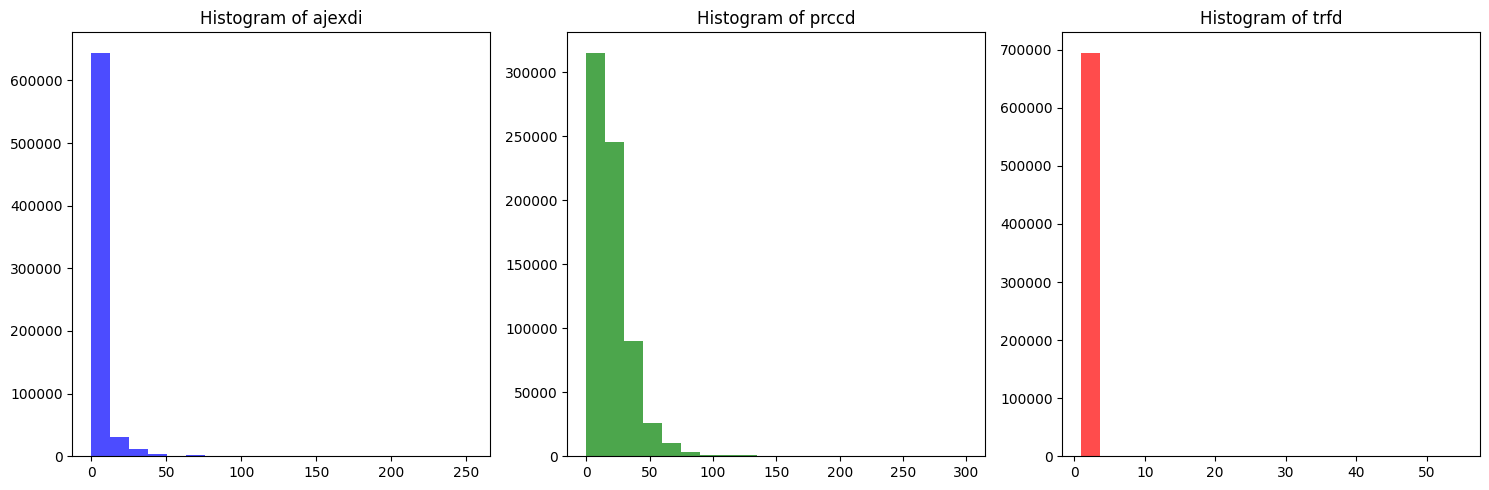

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stacked_ajexdi = pivot_ajexdi.stack().reset_index(name='ajexdi')
stacked_prccd = pivot_prccd.stack().reset_index(name='prccd')
stacked_trfd = pivot_trfd.stack().reset_index(name='trfd')

# Summary statistics
summary_ajexdi = stacked_ajexdi['ajexdi'].describe()
summary_prccd = stacked_prccd['prccd'].describe()
summary_trfd = stacked_trfd['trfd'].describe()

print("Summary statistics for 'ajexdi':")
print(summary_ajexdi)

print("\nSummary statistics for 'prccd':")
print(summary_prccd)

print("\nSummary statistics for 'trfd':")
print(summary_trfd)

# Plot histograms
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(stacked_ajexdi['ajexdi'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Histogram of ajexdi')

plt.subplot(1, 3, 2)
plt.hist(stacked_prccd['prccd'].dropna(), bins=20, color='green', alpha=0.7)
plt.title('Histogram of prccd')

plt.subplot(1, 3, 3)
plt.hist(stacked_returns['trfd'].dropna(), bins=20, color='red', alpha=0.7)
plt.title('Histogram of trfd')

plt.tight_layout()
plt.show()

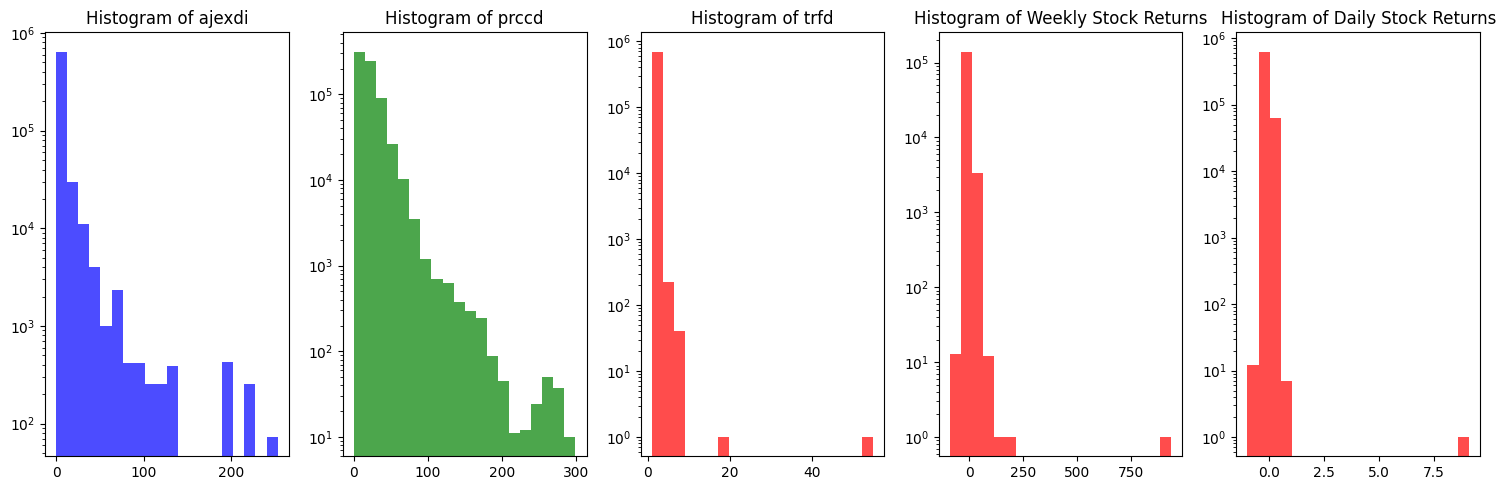

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 5, 1)
plt.hist(stacked_ajexdi['ajexdi'].dropna(), bins=20, color='blue', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of ajexdi')

plt.subplot(1, 5, 2)
plt.hist(stacked_prccd['prccd'].dropna(), bins=20, color='green', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of prccd')

plt.subplot(1, 5, 3)
plt.hist(stacked_trfd['trfd'].dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of trfd')

plt.subplot(1, 5, 4)
plt.hist(stacked_returns.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Weekly Stock Returns')


stacked_daily_returns = pivot_df.stack()
plt.subplot(1, 5, 5)
plt.hist(stacked_daily_returns.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Daily Stock Returns')

plt.tight_layout()
plt.show()


In [15]:
stacked_daily_returns.describe()

count   692340.00
mean        -0.00
std          0.03
min         -0.98
25%         -0.01
50%          0.00
75%          0.01
max          9.07
dtype: float64

In [16]:
# Calculate mean and standard deviation of daily returns
mean_daily_return = pivot_df.mean()
std_daily_return = pivot_df.std()

# Define upper and lower bounds for outliers based on mean ± 3 standard deviations
upper_bound = mean_daily_return + 3 * std_daily_return
lower_bound = mean_daily_return - 3 * std_daily_return

# Identify outliers using mean ± 3 standard deviations approach
outliers_mean_3sd = (pivot_df > upper_bound) | (pivot_df < lower_bound)

# Count number of outliers and total data points
num_outliers_mean_3sd = outliers_mean_3sd.sum().sum()
total_data_points = pivot_df.notnull().sum().sum()

# Print results
print(f"Number of outliers using mean ± 3 standard deviations approach: {num_outliers_mean_3sd}")
print(f"Total number of data points: {total_data_points}")

# Now you can repeat the process for MAD approach


Number of outliers using mean ± 3 standard deviations approach: 10893
Total number of data points: 692340


In [19]:
import numpy as np

# Calculate median of each column
median_daily_return = pivot_df.median()

# Calculate absolute deviations from the median
abs_deviations = np.abs(pivot_df - median_daily_return)

# Calculate median absolute deviation (MAD) across all tickers
mad_daily_return = abs_deviations.median()

# Define upper and lower bounds for outliers based on median ± 3 MAD
upper_bound_mad = median_daily_return + 3 * mad_daily_return
lower_bound_mad = median_daily_return - 3 * mad_daily_return

# Identify outliers using median ± 3 MAD approach
outliers_mad = (pivot_df > upper_bound_mad) | (pivot_df < lower_bound_mad)

# Count number of outliers using MAD approach
num_outliers_mad = outliers_mad.sum().sum()

# Print results
print(f"Number of outliers using median ± 3 MAD approach: {num_outliers_mad}")


Number of outliers using median ± 3 MAD approach: 104447


Number of outliers removed: 0


In [7]:
pivot_df.stack().describe()

count   692340.00
mean        -0.00
std          0.03
min         -0.98
25%         -0.01
50%          0.00
75%          0.01
max          9.07
dtype: float64

In [11]:
# Calculate mean and standard deviation for each column
mean = pivot_df.mean()
std = pivot_df.std()

# Define the number of standard deviations for outlier detection
num_std = 3

# Determine the lower and upper bounds for outlier detection
lower_bound = mean - num_std * std
upper_bound = mean + num_std * std

# Remove outliers
outliers_removed_df = pivot_df[(pivot_df >= lower_bound) & (pivot_df <= upper_bound)]

# Display the shape of the DataFrame after removing outliers
print("Shape of DataFrame after removing outliers:", outliers_removed_df.shape)


Shape of DataFrame after removing outliers: (260, 2841)


In [13]:
outliers_removed_df.stack().describe()

count   681447.00
mean        -0.00
std          0.02
min         -0.23
25%         -0.01
50%          0.00
75%          0.01
max          0.28
dtype: float64

Text(0.5, 1.0, 'Histogram of Daily Stock Returns')

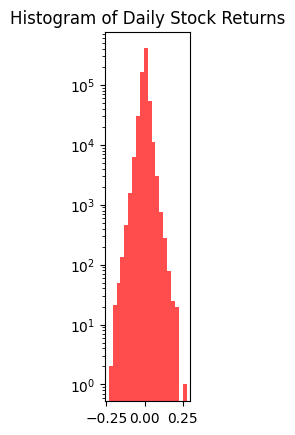

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stacked_daily_returns_outliers_removed = outliers_removed_df.stack()
plt.subplot(1, 5, 5)
plt.hist(stacked_daily_returns_outliers_removed.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Daily Stock Returns')

In [15]:
# Calculate median for each column
median = pivot_df.median()

# Calculate absolute deviations from the median
abs_deviations = np.abs(pivot_df - median)

# Calculate median absolute deviation (MAD)
mad = abs_deviations.median()

# Define the threshold for outlier detection (e.g., 3 times MAD)
threshold = 3

# Determine the lower and upper bounds for outlier detection
lower_bound = median - threshold * mad
upper_bound = median + threshold * mad

# Remove outliers
outliers_removed_df2 = pivot_df[(pivot_df >= lower_bound) & (pivot_df <= upper_bound)]

# Display the shape of the DataFrame after removing outliers
print("Shape of DataFrame after removing outliers using MAD:", outliers_removed_df.shape)


Shape of DataFrame after removing outliers using MAD: (260, 2841)


Text(0.5, 1.0, 'Histogram of Daily Stock Returns')

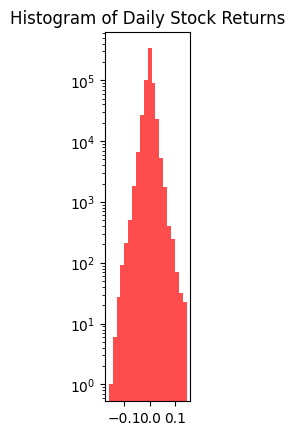

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
stacked_daily_returns_outliers_removed2 = outliers_removed_df2.stack()
plt.subplot(1, 5, 5)
plt.hist(stacked_daily_returns_outliers_removed2.dropna(), bins=20, color='red', alpha=0.7)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Histogram of Daily Stock Returns')

In [17]:
outliers_removed_df2.stack().describe()

count   587893.00
mean        -0.00
std          0.01
min         -0.16
25%         -0.01
50%          0.00
75%          0.00
max          0.14
dtype: float64

In [18]:


outliers_removed_df = outliers_removed_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = outliers_removed_df.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_pivot_1984.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_pivot_1984.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  3234B  3614B  3ACDGE  3ACKH  3ACTRQ  3ADLN  \
1984-01-09   0.00  -0.11   0.04  -0.11   0.01    0.02  -0.01    0.04  -0.02   
1984-01-16   0.00  -0.03  -0.03  -0.01  -0.06    0.09  -0.04   -0.03  -0.05   
1984-01-23   0.00  -0.09  -0.01   0.01   0.03    0.02  -0.03   -0.08   0.00   
1984-01-30  -0.00  -0.07   0.02   0.00   0.01    0.03  -0.06   -0.04  -0.03   
1984-02-06   0.01  -0.10  -0.02  -0.05  -0.04   -0.09  -0.03   -0.20  -0.05   
1984-02-13  -0.01   0.00   0.02   0.00   0.00   -0.05  -0.05   -0.08  -0.03   
1984-02-20   0.00   0.02   0.01   0.01  -0.07    0.01   0.01    0.10   0.00   
1984-02-27  -0.00  -0.05  -0.05   0.01   0.08   -0.02   0.07   -0.05  -0.05   
1984-03-05  -0.02  -0.21   0.03  -0.03  -0.03    0.00  -0.02   -0.07  -0.03   
1984-03-12   0.01  -0.03  -0.04  -0.02  -0.04   -0.05   0.05    0.01  -0.03   

tic         3ADOT.  ...  ZGCO  ZIGO

In [20]:
weekly_pivot_df.stack().describe()

count   143357.00
mean        -0.00
std          0.04
min         -0.45
25%         -0.02
50%          0.00
75%          0.02
max          0.50
dtype: float64